In [1]:
import torch.nn as nn
import torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data.dataloader import data_generator, data_generator_2types
from training.optimizer import get_optimizer
from models.losses import loss_function
from models.utils import eigen_decomp

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiser

à evoquer calcul dans GRU :
$$\hat{\Sigma} = \hat{Q} \hat{\Lambda} \hat{Q}^T$$

$$\tilde{\Sigma}_{NN} = \hat{Q} \tilde{\Lambda}_{NN} \hat{Q}^T$$

## NN

In [5]:
model = BiGRUSpectralDenoiser(hidden_size=64) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

### Training loop

On pourra rajouter dans la loss un terme pour comparer les valeurs propres/les matrices totals par exemples des matrices.

On pourrait calculer la loss par epochs d'une tailles plus petites ou même aléatoire

In [6]:
class Trainer:
    def __init__(self, model, loss_function, data_generator, lr, weight_decay, batch_size,
        epochs, N_min, N_max, T_min, T_max, log_interval, accumulate_steps
    ): 
        self.model = model
        self.optimizer = get_optimizer(model, lr=lr, weight_decay=weight_decay)
        self.loss_function = loss_function
        self.data_generator = data_generator
        self.batch_size = batch_size
        self.epochs = epochs
        self.N_min = N_min
        self.N_max = N_max
        self.T_min = T_min
        self.T_max = T_max
        self.log_interval = log_interval
        self.accumulate_steps = accumulate_steps

        self.loss_history = []
    
    def _prepare_batch(self, batch):
        lam_emp, Q_emp, Sigma_true, T, Tmin, Tmax = batch

        lam_emp = lam_emp
        Q_emp   = Q_emp
        Sigma_true = Sigma_true
        Tmin = Tmin.float()
        Tmax = Tmax.float()

        # Build conditioning scalars
        T_vec = torch.full((lam_emp.shape[0], lam_emp.shape[1], 1), T)
        N_vec = torch.full((lam_emp.shape[0], lam_emp.shape[1], 1), lam_emp.shape[1])

        # Build input sequence to the GRU
        input_seq = torch.cat([lam_emp, N_vec/T_vec, Tmin, Tmax], dim=-1)

        return input_seq, Q_emp, Sigma_true, T
    
    def train(self):
        print(f"Starting training for {self.epochs} epochs…")

        generator = self.data_generator(
            self.batch_size,
            N_min=self.N_min, N_max=self.N_max,
            T_min=self.T_min, T_max=self.T_max
        )

        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            
            for _ in range(self.accumulate_steps):  # accumulate gradients over multiple batches
                batch = next(generator)
                input_seq, Q_emp, Sigma_true, T = self._prepare_batch(batch)

                # forward
                lam_pred = self.model(input_seq)

                # loss
                loss = self.loss_function(lam_pred, Q_emp, Sigma_true, T)
                (loss/ self.accumulate_steps).backward()

            self.optimizer.step()

            self.loss_history.append(loss.item())

            # logging
            if (epoch + 1) % self.log_interval == 0:
                print(f"Epoch {epoch+1}/{self.epochs} — loss: {loss.item():.6f}")

        print("Training complete.")
        return self.loss_history

In [7]:
trainer = Trainer(
    model=model, loss_function=loss_function, data_generator=data_generator, lr = 5e-3, weight_decay=1e-6,
    batch_size=32, epochs=600, N_min=150, N_max=150, T_min=200, T_max=200, log_interval=10, accumulate_steps=1
)

losses = trainer.train()

Starting training for 600 epochs…


/Users/Utilisateur1/covariance-cleaning/.venv/lib/python3.11/site-packages/torch/distributions/wishart.py:279: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


Epoch 10/600 — loss: 898321.812500
Epoch 20/600 — loss: 890322.250000
Epoch 30/600 — loss: 874580.625000
Epoch 40/600 — loss: 860935.312500
Epoch 50/600 — loss: 844685.750000
Epoch 60/600 — loss: 831936.250000
Epoch 70/600 — loss: 817645.750000
Epoch 80/600 — loss: 805150.000000
Epoch 90/600 — loss: 792103.437500
Epoch 100/600 — loss: 779528.875000
Epoch 110/600 — loss: 770024.062500
Epoch 120/600 — loss: 757870.000000
Epoch 130/600 — loss: 745953.250000
Epoch 140/600 — loss: 732556.687500
Epoch 150/600 — loss: 721863.125000
Epoch 160/600 — loss: 712131.625000
Epoch 170/600 — loss: 701758.812500
Epoch 180/600 — loss: 690796.000000
Epoch 190/600 — loss: 679466.250000
Epoch 200/600 — loss: 670163.750000
Epoch 210/600 — loss: 659507.250000
Epoch 220/600 — loss: 648710.625000
Epoch 230/600 — loss: 641655.000000
Epoch 240/600 — loss: 630624.750000
Epoch 250/600 — loss: 620050.375000
Epoch 260/600 — loss: 610814.312500
Epoch 270/600 — loss: 602909.750000
Epoch 280/600 — loss: 592665.000000
E

identified 2 major problemof divergence : 
- when T and N are changing, loss Is not converging
- when df changes it doesn't work either

with a lot of hidden layer, potentially learning on average very slow...

In [8]:
# save the model
# torch.save(model.state_dict(), "models/spectral_denoiser_model32-bis.pth")

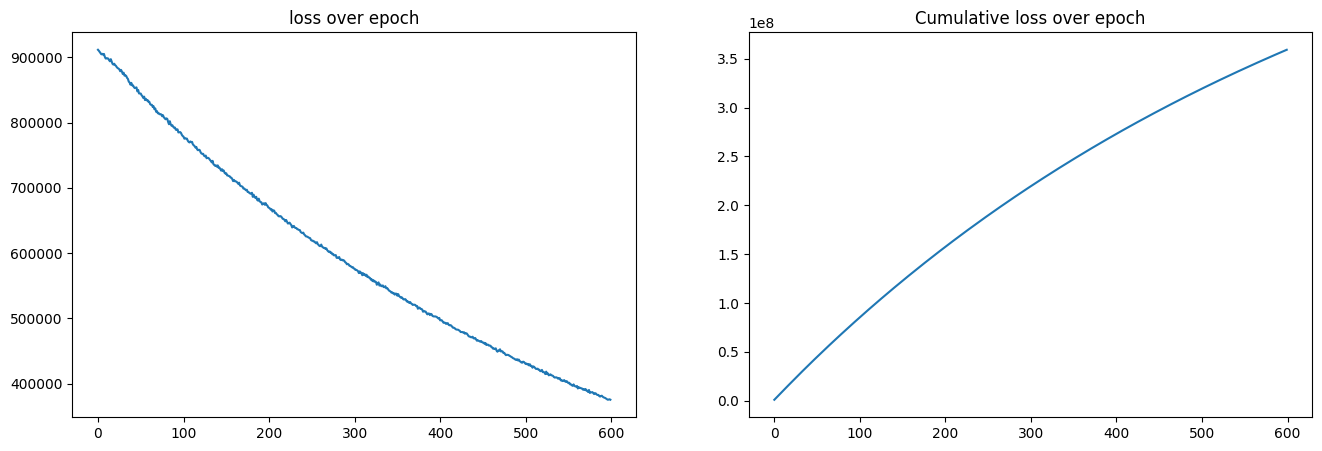

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.subplot(1,2,2)
plt.plot(np.cumsum(losses))
plt.title("Cumulative loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

the second figure need to be ln type at first

might go up and down because it really depends on the N and T randomly picked.

we have to stop after the slow down of deacrese. otherwise we might face overfitting

### out of sample comparaison 1

In [154]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [155]:
losses_value = []

In [156]:
for n in N_list_test_1:
    for t in T_list_test_1:
        lam_emp_oos_i, Q_emp_oos_i, Sigma_true_oos_i, T_t, Tmin, Tmax = next(data_generator(batch_size_oos_1, N_min=n, N_max=n, T_min=t, T_max=t))
        T_vec = torch.full((batch_size_oos_1, lam_emp_oos_i.shape[1], 1), T_t)
        N_vec = torch.full((batch_size_oos_1, lam_emp_oos_i.shape[1], 1), len(lam_emp_oos_i))

        input_seq = torch.cat([lam_emp_oos_i,T_vec, N_vec, Tmin, Tmax], dim=-1) 
        lam_pred_test_i = model(input_seq)
        losses_value.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())

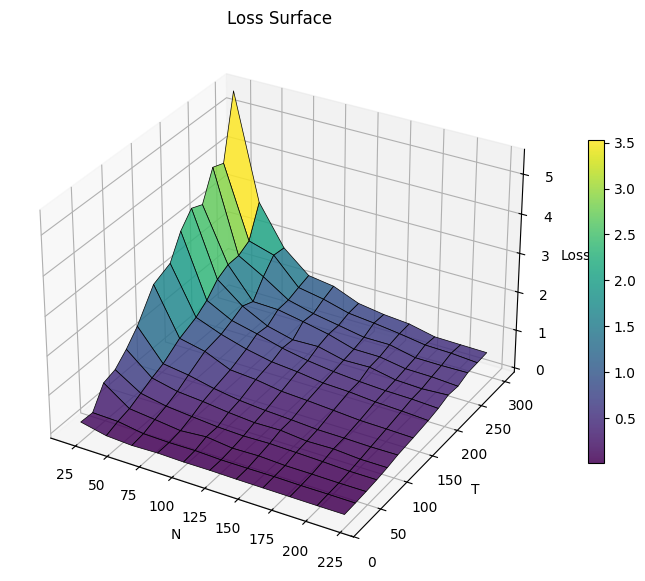

In [157]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

### out of sample comparaison 2

In [158]:
batch_size_oos = 512

In [ ]:
lam_emp_oos, Q_emp_oos, Sigma_true_oos, T, Tmin, Tmax, lam_emp_1_oos, Q_emp_1_oos, Sigma_hat = next(data_generator_2types(batch_size_oos, N_min=200, N_max=200, T_min=100, T_max=100))

In [160]:
T_vec = torch.full((lam_emp_oos.shape[0], lam_emp_oos.shape[1], 1), T)
N_vec = torch.full((lam_emp_oos.shape[0], lam_emp_oos.shape[1], 1), lam_emp_oos.shape[1])

# Build input sequence to the GRU
input_seq = torch.cat([lam_emp_oos, T_vec, N_vec, Tmin, Tmax], dim=-1)

lam_pred_test = model(input_seq)

Comparaison eigenvalues $\lambda$

In [161]:
# mse
mse = nn.MSELoss()

In [162]:
lam_true_oos = torch.tensor(np.array([eigen_decomp(Sigma.numpy())[0] for Sigma in Sigma_true_oos]), dtype=torch.float32)


mse_pred_test_lam  = mse(lam_pred_test, lam_true_oos)
mse_noisy_test_lam = mse(lam_true_oos, lam_emp_oos.squeeze(-1))
mse_shaffer_test_lam = mse(lam_true_oos, lam_emp_1_oos.squeeze(-1))


print(f"MSE cleaned: {mse_pred_test_lam:.6f}")
print(f"MSE noisy  : {mse_noisy_test_lam:.6f}")
print(f"MSE Shaffer  : {mse_shaffer_test_lam:.6f}")

MSE cleaned: 0.113831
MSE noisy  : 0.197046
MSE Shaffer  : 1079575552.000000


Comparaison Trace

In [163]:
trace_true_test = lam_true_oos.sum(dim=1).mean()
trace_pred_test = lam_pred_test.sum(dim=1).mean()
trace_noisy_test = lam_emp_oos.sum(dim=1).mean()
trace_shaffer_test = lam_emp_1_oos.sum(dim=1).mean()

mse_tr_test_pred = mse(trace_true_test,trace_pred_test)
mse_tr_test_noisy = mse(trace_true_test,trace_noisy_test)
mse_tr_test_shaffer = mse(trace_true_test,trace_shaffer_test)

print(f"Real Trace : {trace_true_test:.4f}, predicted : {trace_pred_test:.4f}, noisy : {trace_noisy_test:.4f}, shaffer : {trace_shaffer_test:.4f}")

print(f"MSE tr cleaned: {mse_tr_test_pred:.6f}")
print(f"MSE tr noisy  : {mse_tr_test_noisy:.6f}")
print(f"MSE tr shaffer: {mse_tr_test_shaffer:.6f}")

Real Trace : 53.5583, predicted : 80.0150, noisy : 53.5971, shaffer : 21594.9727
MSE tr cleaned: 699.959351
MSE tr noisy  : 0.001513
MSE tr shaffer: 464032512.000000


*10^6 fois mieux

Comparaison matrix $\Sigma$

In [164]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam.squeeze(-1))
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [165]:
Sigma_true_test = Sigma_true_oos
Sigma_noisy_test = reconstruct_cov(Q_emp_oos, lam_emp_oos)
Sigma_pred_test   = reconstruct_cov(Q_emp_oos, lam_pred_test)
Sigma_shaffer_test   = reconstruct_cov(Q_emp_1_oos, lam_emp_1_oos)

fro_noisy_test_mat = mse(Sigma_noisy_test, Sigma_true_test)
fro_pred_test_mat   = mse(Sigma_pred_test, Sigma_true_test)
fro_shaffer_test_mat   = mse(Sigma_shaffer_test, Sigma_true_test)

print(f"mse error (GRU)  :  {fro_pred_test_mat:.6f}")
print(f"mse error (noisy):  {fro_noisy_test_mat:.6f}")
print(f"mse error (Shaffer)  :  {fro_shaffer_test_mat:.6f}")

mse error (GRU)  :  0.000566
mse error (noisy):  0.001938
mse error (Shaffer)  :  5397874.500000


supérieur à *10^6 fois mieux

Graphique : 

In [166]:
pairs = ['Matrix', 'Trace', 'EigenValues']
mse_noisy   = [fro_noisy_test_mat.item(), mse_tr_test_noisy.item(), mse_noisy_test_lam.item()]
mse_cleaned = [fro_pred_test_mat.item(), mse_tr_test_pred.item(), mse_pred_test_lam.item()]
mse_shaffer = [fro_shaffer_test_mat.item(), mse_tr_test_shaffer.item(), mse_shaffer_test_lam.item()]

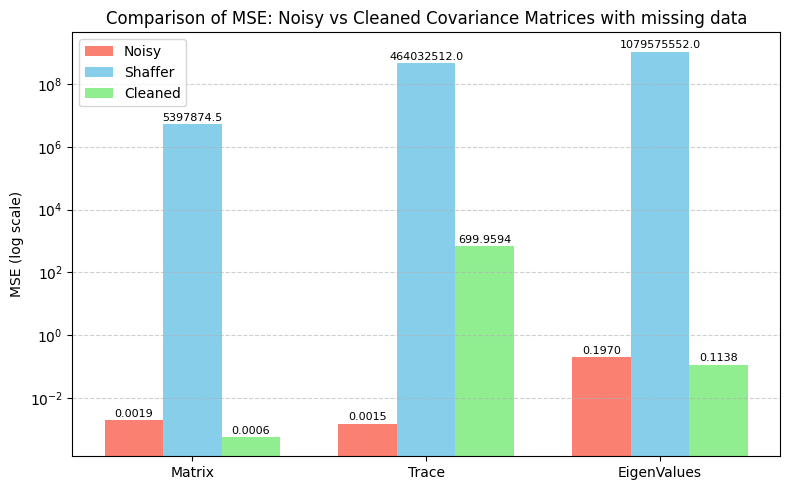

In [167]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, mse_noisy, width, label='Noisy', color='salmon')
plt.bar(x, mse_shaffer, width, label='Shaffer', color='skyblue')
plt.bar(x + width, mse_cleaned, width, label='Cleaned', color='lightgreen')

plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c, s) in enumerate(zip(mse_noisy, mse_cleaned, mse_shaffer)):
    plt.text(x[i] - width, n*1.1, f"{n:.4f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i], s*1.1, f"{s:.1f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width, c*1.1, f"{c:.4f}", ha='center', va='bottom', fontsize=8)

plt.title('Comparison of MSE: Noisy vs Cleaned Covariance Matrices with missing data')
plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()


### Add comparaison

#### Comparaison with no missing value

#### Comparaison with RIE estimator on no missing value

### Add hyperparameter selection

### Loss that minimizes the Portfolio Risk

Week timeline : 
- remove comparaison with trace : if necessary it can be normalized at the output of our network $\lambda_j * N / \sum_{i=1}^{N}\lambda_i $
- remove comparaison with eigenvalues : not meaning full as they are in another base !
- use the naiv estimator
- comparaison between GRU estimator and naiv estim
- comparaison between GRU estimator and the one from shaffer's book
- provide the GRU with x_i = {l_i, T} => find a way to give it the mask without making it dependant on some size

To be added
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning
- k split cross validation
- try stochastic gradient descent

To be written in the report
- write abt RIE and that we do smt simular
- write abt GRU and how it helps us here
- a problem is that eigenVector are noisy